**Table of contents**<a id='toc0_'></a>    
- 1. [Imports](#toc1_)    
  - 1.1. [Data import](#toc1_1_)    
- 2. [Introduction](#toc2_)    
  - 2.1. [Preliminary data description](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Imports](#toc0_)

In [1]:
import polars as pl
import geopandas as gpd
import pandas as pd
from data import county_demographics
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1.1. <a id='toc1_1_'></a>[Data import](#toc0_)

In [2]:
# Here I define a list to download data relevant to this project. Some of the files are quite large and so does not play that nice with GitHub
list_of_files = [
    ("arcos_appa.pq", "https://drive.google.com/file/d/1oafBFTnaCH1SsZluD0S6nnunIDnSVNKB/view?usp=sharing"),
    ("us_appa_counties.pq", "https://drive.google.com/file/d/11U4IpBHGpfok_oR0f7aRUckBS_vkEKn7/view?usp=sharing"),
    ("us_appa_states.pq", "https://drive.google.com/file/d/1sAUS4KIBUz2g4x0SNwTZnCMLK1MM3CzZ/view?usp=sharing")
]

# Check whether user has files downloaded, if not then download
# Kindly refer to the file 0_datapreprocess.py to see how I parse the data reduce size
for file, url in list_of_files:
    if not os.path.exists(f'data/{file}'):
        output = f"data/{file}"
        gdown.download(url, output, fuzzy=True)

# 2. <a id='toc2_'></a>[Introduction](#toc0_)

The opioid epidemic remains one of, if not the greatest threat to public health in America. Its origins have been dramatized on TV-shows such as [Dopesick](https://en.wikipedia.org/wiki/Dopesick_(miniseries)) and studied extensively in the academic litterature. In particular, Evans et al. [(2019)](https://direct.mit.edu/rest/article-abstract/101/1/1/58660/How-the-Reformulation-of-OxyContin-Ignited-the) attribute the introductio of a abuse-dettering version of the popular synthetic opioid OxyContin in 2010 to have ignited the Heroin Epidemic. 

It is around this period of the reformulation that is of particular interest to me. Specifically, I analyse a dataset derived from the Drug Enforcement Agency (DEA) that maps individual opioid drug shipments to commercial buyers (pharmacies, practitioners). I aim to see whether the reformulation seem to have caused a reduction in opioid shipments. 

It is important to note that the full dataset contains shipments dating from 2006-2012 (and has since been extended to 2019) with ~180+ million observations. This means that "raw" `.csv` data takes up 120+ GB(!). To limit this analysis and reduce dimensionality:

1) Only look at the years 2009-2011
2) Aim my focus on the Appalachians

To see how I do this, kindly refer to the `0_datapreprocess.py`-file found in the repository. Regarding 2), I do this to have an overlap with [Dopesick](https://en.wikipedia.org/wiki/Dopesick_(miniseries)) that takes place in and around this region. With that, let us dive into the data.

## 2.1. <a id='toc2_1_'></a>[Preliminary data description](#toc0_)

In [3]:
# Read in data
lf = pl.scan_parquet('data/arcos_appa.pq').sort('transaction_date')

# Inspect top of dataset
lf.fetch(5)

reporter_dea_no,buyer_dea_no,buyer_bus_act,buyer_state,drug_code,drug_name,mme_conversion_factor,quantity,transaction_code,transaction_date,calc_base_wt_in_gm,dosage_unit,product_name,ingredient_name,revised_company_name,dos_str
str,str,cat,cat,cat,cat,f32,f32,cat,date,f32,f32,cat,cat,str,f32
"""PB0167127""","""AH2484789""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2009-05-20,3.027,500.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Amneal Pharmac…",10.0
"""PB0167127""","""AH2484789""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2009-10-26,3.027,500.0,"""HYDROCODONE.BI…","""HYDROCODONE BI…","""Amneal Pharmac…",10.0
"""PB0167127""","""AH2484789""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2011-01-03,3.027,500.0,"""HYDROCODO.BIT …","""HYDROCODONE BI…","""Endo Pharmaceu…",10.0
"""PB0167127""","""AH2484789""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,2.0,"""S""",2011-06-09,3.027,1000.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Mallinckrodt""",5.0
"""PB0167127""","""AH2484789""","""RETAIL PHARMAC…","""VA""","""9193""","""HYDROCODONE""",1.0,1.0,"""S""",2011-08-11,1.5135,500.0,"""HYDROCODONE BI…","""HYDROCODONE BI…","""Amneal Pharmac…",5.0


In [4]:
# Give me the columns
cols = lf.columns 

# Read metadata
df_meta = pl.read_csv('data/data_dictionary.csv')

# Lower case column names 
cols_meta = df_meta.with_columns(pl.col("ColumnName").str.to_lowercase()).filter(pl.col("ColumnName").is_in(cols))

col_names = cols_meta.select(pl.col("ColumnName")).to_series().to_list()
col_names_descrip = cols_meta.select(pl.col("Description")).to_series().to_list()

cols_description={col: name for col,name in zip(col_names, col_names_descrip)}
cols_description

{'reporter_dea_no': 'Unique id of entity reporting shipments to DEA. Reporters must have unique id for each facility, so some reporters have multiple ids.',
 'buyer_dea_no': 'Unique id of entity receiving shipments from reporter.',
 'buyer_bus_act': 'Type of business the reporter does. Our data set limits to retail pharmacies, chain pharmacies and types of practitioners, though full data set includes more including mail order pharmacies, hospitals and distributors, among others.',
 'buyer_state': 'State of entity receiving shipments from reporter.',
 'transaction_code': 'Code determining whether a transaction increases or decreases the reporter\'s inventory. Post data contains only those with code "S" for sale, though the full data includes more transaction types including returns and shipments lost in transit, among others.',
 'drug_code': 'A four-digit Controlled Substance Code Number that identifies the shipped, regardless of form (pills, patches or nasal sprays, among others) or si

In [5]:
# What are the type of drugs in this dataset
print(f'The type of drugs in this dataset: {lf.select(pl.col("drug_name").unique()).collect()}')

# Which type of buyers?
print(f'Buyers available in this dataset: {lf.select(pl.col("buyer_bus_act").unique()).collect()}')

The type of drugs in this dataset: shape: (2, 1)
┌─────────────┐
│ drug_name   │
│ ---         │
│ cat         │
╞═════════════╡
│ OXYCODONE   │
│ HYDROCODONE │
└─────────────┘
Buyers available in this dataset: shape: (2, 1)
┌─────────────────┐
│ buyer_bus_act   │
│ ---             │
│ cat             │
╞═════════════════╡
│ RETAIL PHARMACY │
│ CHAIN PHARMACY  │
└─────────────────┘


*Note*: One row in the dataset is one "transaction"/shipment from manufacturer to buyer. Because each shipment vary in size (number of pills) and dose strength, I would like a column with total dosage and total dosage scaled by the mme_conversion_factor:

\begin{align}
total\_dos &= quantity \times dosage\_unit \times dos\_str \\
total\_dos\_MME &= total\_dos \times mme\_conversion\_factor
\end{align}

In [5]:
# Make above-mentioned columns
lf=(lf
    .with_columns(
        (pl.col("quantity").mul(pl.col("dosage_unit")).mul(pl.col("dos_str")).alias("total_dos"))
    ).with_columns(
        (pl.col("total_dos").mul(pl.col("mme_conversion_factor")).alias("total_dos_mme"))
    )

)

# I'd also like what county the buyer (pharmacy) is in 
# To do that I load the county shape file
gdf_counties = gpd.read_parquet('data/us_appa_counties.pq')
lf_pharm = pl.scan_parquet('data/pharmacies_latlon.pq').select(pl.col("buyer_dea_no", "geoid"))

lf=lf.join(lf_pharm, left_on='buyer_dea_no', right_on='buyer_dea_no')

reporter_dea_no,buyer_dea_no,buyer_bus_act,buyer_state,drug_code,drug_name,mme_conversion_factor,quantity,transaction_code,transaction_date,calc_base_wt_in_gm,dosage_unit,product_name,ingredient_name,revised_company_name,dos_str,total_dos,total_dos_mme,geoid
str,str,cat,cat,cat,cat,f32,f32,cat,date,f32,f32,cat,cat,str,f32,f32,f32,str


# Data analysis
## Total dosage

In [6]:
df_total_dos_per_pharm=lf.group_by(pl.col("buyer_dea_no"), pl.col("transaction_date").dt.year()).agg((pl.col("total_dos_mme").sum()/1000/1000).alias("total_dos_mme_kg")).collect()
df_total_dos_per_pharm.head()

buyer_dea_no,transaction_date,total_dos_mme_kg
str,i32,f32
"""BA2029949""",2010,2.60105
"""BP7582059""",2009,4.81805
"""BU8641169""",2010,465.522339
"""AM8812871""",2011,3.761777
"""FW1683590""",2010,6.582876


(0.5, 40.0)

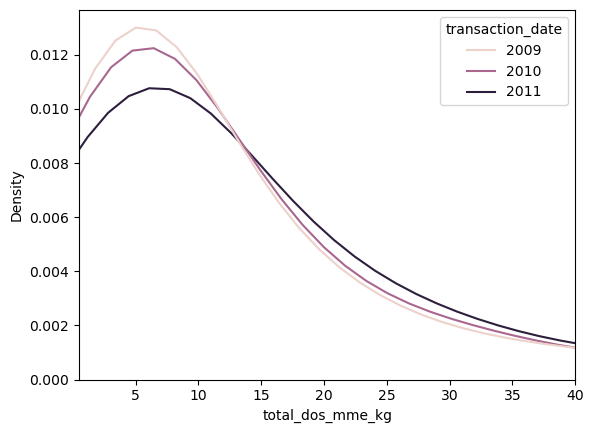

In [7]:
df_total_dos_per_pharm_sub = df_total_dos_per_pharm.filter(pl.col("total_dos_mme_kg").is_between(0.5,300))
plot = sns.kdeplot(data=df_total_dos_per_pharm_sub, x='total_dos_mme_kg', hue="transaction_date")
plot.set_xlim(0.5,40)

Add on per capita info...

In [8]:
df_total_dos_per=lf.group_by_dynamic('transaction_date', every='1mo', group_by='geoid').agg(pl.col("total_dos_mme").sum()).collect()
df_total_dos_per.head()

geoid,transaction_date,total_dos_mme
str,date,f32
"""47057""",2009-01-01,1.6287125e7
"""47057""",2009-02-01,1.005075e7
"""47057""",2009-03-01,2.1331128e7
"""47057""",2009-04-01,1.549175e7
"""47057""",2009-05-01,1.4505625e7


In [10]:
gdf_counties = gpd.read_parquet('data/us_appa_counties.pq')
gdf_states = gpd.read_parquet('data/us_appa_states.pq')
gdf_pharm = gpd.read_parquet('data/pharmacies_latlon.pq')

## Pharmacies

<Axes: >

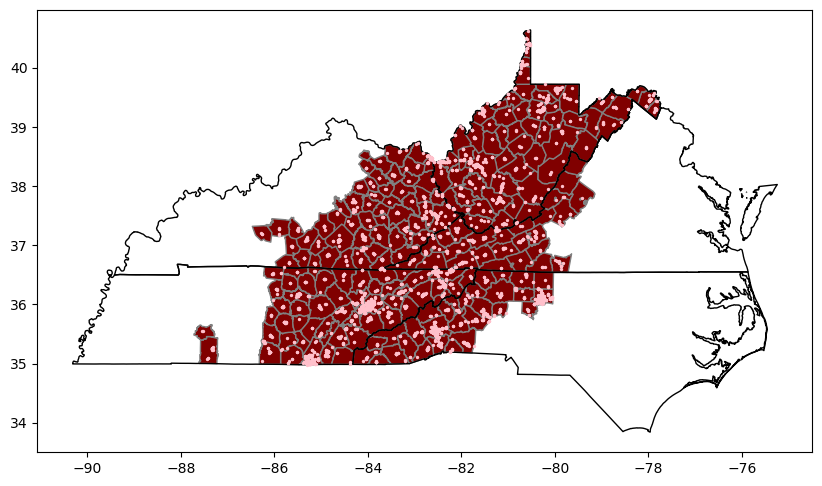

In [13]:
fig,ax = plt.subplots(figsize=(10,6))
gdf_counties.plot(ax=ax, color='maroon', edgecolor='grey')
gdf_states.plot(ax=ax, color='none', edgecolor='k')
gdf_buyers.plot(ax=ax, markersize=2, color="pink") # Retail/chain pharmacies hue? How to do in matplotlib
ax.set_axis_off()

*To do*
- Map of pharmacies (retail/chain)
- Map of income
- Agg per capita mme_dosage
- Line plot by month of mme_dosage